# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:22:43.799404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:22:43.799466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:22:43.800932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-7, who has ID: A3CG93783LP0FO

In [2]:
parameters = {}

user = "users-7"
user_id = "A3CG93783LP0FO"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A3LSI954URFAJ3,B000084EEF,B004JBB22G,B015D67968
1,A3PZARP3I8BWZH,B000084EEF,B00WMMMHNM,B00UXY3NM0
2,A19YJWD8OAZX2S,B000084EEF,B01AT89OEA,B018OI4I66
3,A19YJWD8OAZX2S,B0002AS1CC,B018OI4I66,B000084EEF
4,A2RSXF64W7VW31,B000084EEF,B000QOIX4U,B0006G511G
...,...,...,...,...
35012,A3HBFMI2F722GC,B01DGQJE8S,B00M7GP5DW,B004X6UEH6
35013,ARY8SOWYJN3F0,B01DGQJE8S,B0029N92JG,B0090Z9CW8
35014,A2PYNU00SUE3IT,B01DOP5L4M,B0018ZKNYE,B013LAGHKW
35015,A3R4MR8BHDT7IJ,B01DOP5L4M,B005FUEKUQ,B007E9VDF6


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 35017
Number of sequences and targets after removal: 34360


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A3CG93783LP0FO
productID                 B00I9SI40S
purchased_before_1        B01DGQJE8S
purchased_before_2        B014HCXECW
Name: 3343, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 34359
Number of sequences and targets after dropping duplicates: 30548


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 101
Number of unique product IDs in sequences: 16118


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B004JBB22G', 'B015D67968'],
        ['B00WMMMHNM', 'B00UXY3NM0'],
        ['B000QOIX4U', 'B0006G511G'],
        ['B014E2AGYE', 'B004V4BXTI'],
        ['B0002DIRXC', 'B00OILVTES'],
        ['B004XZB0QQ', 'B001TA5O9C'],
        ['B00O3GWKY6', 'B001LUO1K8'],
        ['B0151JV6MK', 'B017P1QSC0'],
        ['B002CJAOPI', 'B001CGN5PS'],
        ['B000084EXU', 'B000IVGBFY']], dtype=object),
 array(['B000084EEF', 'B000084EEF', 'B000084EEF', 'B000084EEF',
        'B000084EEF', 'B000084EEF', 'B004XZB0QQ', 'B000084EEF',
        'B000084EEF', 'B000UGB9EA'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[39213, 125538],
        [115747, 113153],
        [16286, 7620],
        [124024, 41116],
        [4429, 103905],
        [41871, 27662],
        [103139, 26103],
        [125048, 129218],
        [30165, 23503],
        [328, 13543]], dtype=object),
 array([275, 275, 275, 275, 275, 275, 41871, 275, 275, 17244], dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 24434
Number of validation sequences: 3056
Number of test sequences: 3058

Number of train targets: 24434
Number of validation targets: 3056
Number of test targets: 3058

Number of classes (unique product IDs) in the train targets: 101
Number of classes in the validation targets: 101
Number of classes in the test targets: 101


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([48684, 32270], dtype=object),
 array([73884, 40853], dtype=object),
 array([105352, 70595], dtype=object),
 array([50921, 87667], dtype=object),
 array([4041, 56190], dtype=object),
 array([105565, 110160], dtype=object),
 array([123001, 3088], dtype=object),
 array([20420, 10959], dtype=object),
 array([14858, 134178], dtype=object),
 array([74474, 91220], dtype=object)]

In [19]:
y_train[:10]

[275, 275, 275, 275, 275, 275, 275, 275, 275, 275]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/764 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0927 - f1_score: 0.0719 - f1_score_at_k: 0.1516 - hit_rate_at_k: 0.3373 - loss: 11.8299 - ndcg_at_k: 0.0710                     

I0000 00:00:1714591378.726228    7351 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


764/764 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.1715 - f1_score: 0.0709 - f1_score_at_k: 0.1305 - hit_rate_at_k: 0.4497 - loss: 7.4606 - ndcg_at_k: 0.1050 - val_accuracy: 0.1545 - val_f1_score: 0.1663 - val_f1_score_at_k: 0.3467 - val_hit_rate_at_k: 0.3232 - val_loss: 3.8306 - val_ndcg_at_k: 0.0797
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2039 - f1_score: 0.0940 - f1_score_at_k: 0.1564 - hit_rate_at_k: 0.4955 - loss: 3.3123 - ndcg_at_k: 0.1190 - val_accuracy: 0.1666 - val_f1_score: 0.1822 - val_f1_score_at_k: 0.3477 - val_hit_rate_at_k: 0.3161 - val_loss: 3.7528 - val_ndcg_at_k: 0.0814
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2350 - f1_score: 0.1553 - f1_score_at_k: 0.1950 - hit_rate_at_k: 0.5351 - loss: 3.1547 - ndcg_at_k: 0.1313 - val_accuracy: 0.1538 - val_f1_score: 0.1968 - val_f1_score_at_k: 0.4279 - val_hit_rate_at_k: 0.3594 - val_loss: 3.6786 - val_ndcg_at_k: 0.0872
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - a

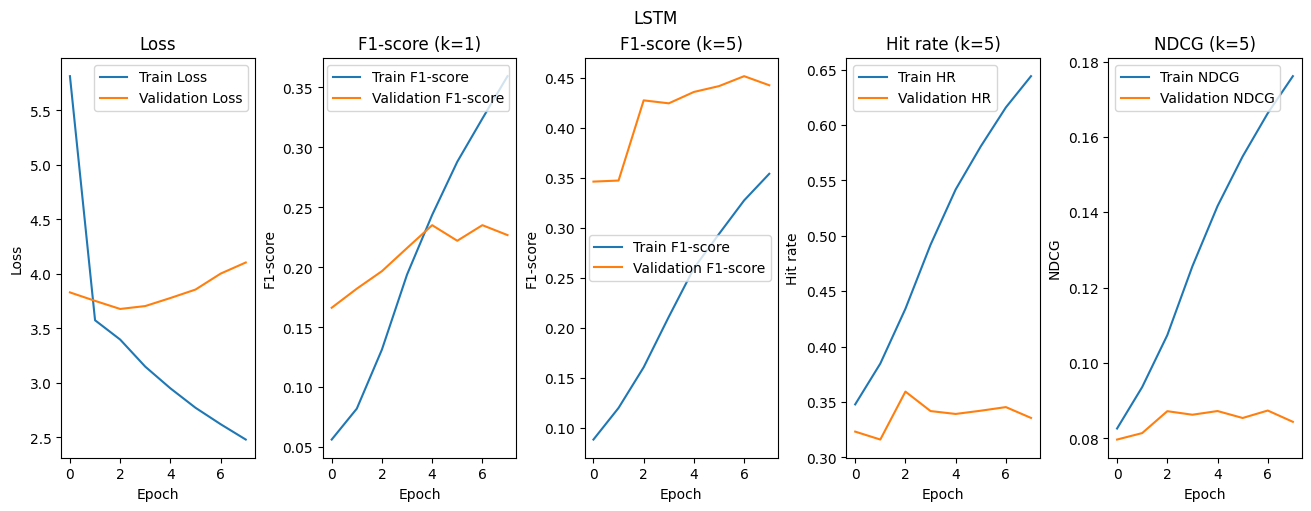

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1320 - f1_score: 0.1995 - f1_score_at_k: 0.4544 - hit_rate_at_k: 0.3344 - loss: 4.0555 - ndcg_at_k: 0.0784
Test loss: 4.1297
Test accuracy: 0.1638
Test F1@1: 0.2366
Test F1@5: 0.4385
Test HR@5: 0.3305
Test NDCG@5: 0.0837


In [32]:
parameters

{'user': 'users-7',
 'user_id': 'A3CG93783LP0FO',
 'number_of_sequences_and_targets_before_removal': 35017,
 'number_of_sequences_and_targets_after_removal': 34360,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 30548,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 16118,
 'number_of_sequences_and_targets_train': 24434,
 'number_of_sequences_and_targets_validation': 3056,
 'number_of_sequences_and_targets_test': 3058,
 'number_of_unique_products_in_targets_train': 101,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.1297197341918945,
 'model_lstm_test_accuracy': 0.1638,
 'model_lstm_test_f1_score_k_1': 0.2366,
 'model_lstm_test_f1_score_k_5': 0.4385,
 'model_lstm_test_hr': 0.3305,
 'model_lstm_test_ndcg': 0.0837}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.1892 - f1_score: 0.0865 - f1_score_at_k: 0.1466 - hit_rate_at_k: 0.4828 - loss: 7.1813 - ndcg_at_k: 0.1136 - val_accuracy: 0.1662 - val_f1_score: 0.1813 - val_f1_score_at_k: 0.3732 - val_hit_rate_at_k: 0.3304 - val_loss: 3.7672 - val_ndcg_at_k: 0.0838
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2272 - f1_score: 0.1403 - f1_score_at_k: 0.1967 - hit_rate_at_k: 0.5309 - loss: 3.1792 - ndcg_at_k: 0.1291 - val_accuracy: 0.1695 - val_f1_score: 0.2135 - val_f1_score_at_k: 0.4249 - val_hit_rate_at_k: 0.3519 - val_loss: 3.6593 - val_ndcg_at_k: 0.0883
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2849 - f1_score: 0.2305 - f1_score_at_k: 0.2549 - hit_rate_at_k: 0.5893 - loss: 2.8878 - ndcg_at_k: 0.1505 - val_accuracy: 0.1672 - val_f1_score: 0.2296 - val_f1_score_at_k: 0.4505 - val_hit_rate_at_k: 0.3545 - val_loss: 3.6650 - val_ndcg_at_k: 0.0884
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 7

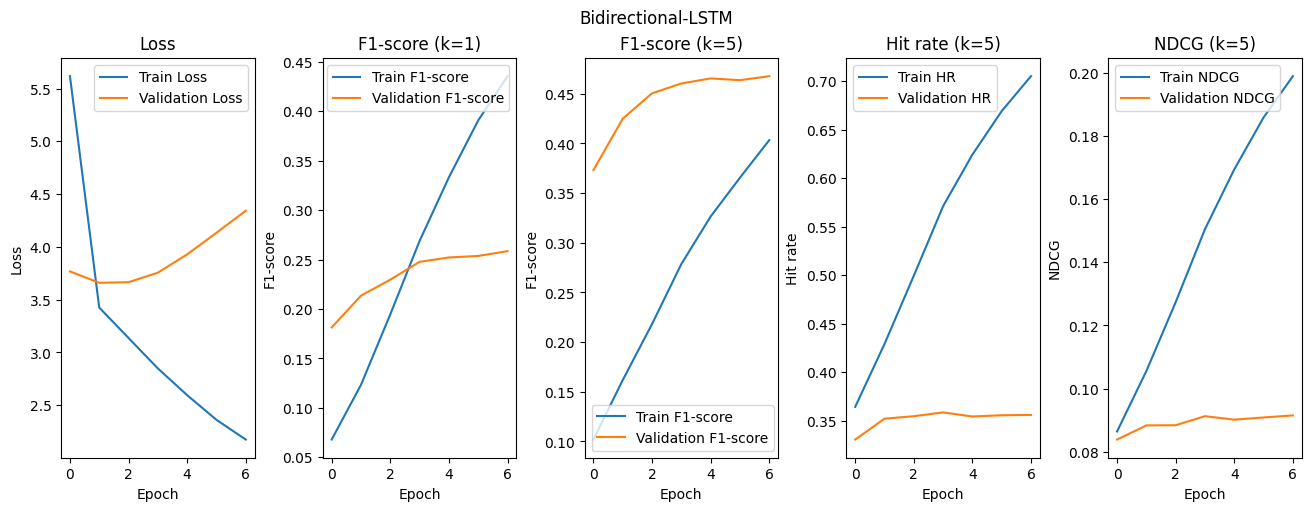

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1486 - f1_score: 0.2268 - f1_score_at_k: 0.4755 - hit_rate_at_k: 0.3546 - loss: 4.2135 - ndcg_at_k: 0.0857
Test loss: 4.356
Test accuracy: 0.1785
Test F1@1: 0.261
Test F1@5: 0.46
Test HR@5: 0.3488
Test NDCG@5: 0.0899


In [37]:
parameters

{'user': 'users-7',
 'user_id': 'A3CG93783LP0FO',
 'number_of_sequences_and_targets_before_removal': 35017,
 'number_of_sequences_and_targets_after_removal': 34360,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 30548,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 16118,
 'number_of_sequences_and_targets_train': 24434,
 'number_of_sequences_and_targets_validation': 3056,
 'number_of_sequences_and_targets_test': 3058,
 'number_of_unique_products_in_targets_train': 101,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.1297197341918945,
 'model_lstm_test_accuracy': 0.1638,
 'model_lstm_test_f1_score_k_1': 0.2366,
 'model_lstm_test_f1_score_k_5': 0.4385,
 'model_lstm_test_hr': 0.3305,
 'model_lstm_test_ndcg': 0.0837,
 'model_bi_lstm_test_loss': 4.355976104736328,
 'model_bi_lstm_test_accuracy': 0.1785,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.1749 - f1_score: 0.0755 - f1_score_at_k: 0.1359 - hit_rate_at_k: 0.4605 - loss: 7.6810 - ndcg_at_k: 0.1079 - val_accuracy: 0.1594 - val_f1_score: 0.1686 - val_f1_score_at_k: 0.3193 - val_hit_rate_at_k: 0.2917 - val_loss: 3.8151 - val_ndcg_at_k: 0.0763
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2149 - f1_score: 0.1106 - f1_score_at_k: 0.1769 - hit_rate_at_k: 0.5022 - loss: 3.2731 - ndcg_at_k: 0.1220 - val_accuracy: 0.1715 - val_f1_score: 0.2151 - val_f1_score_at_k: 0.4122 - val_hit_rate_at_k: 0.3512 - val_loss: 3.6847 - val_ndcg_at_k: 0.0888
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2560 - f1_score: 0.1851 - f1_score_at_k: 0.2245 - hit_rate_at_k: 0.5667 - loss: 3.0512 - ndcg_at_k: 0.1411 - val_accuracy: 0.1636 - val_f1_score: 0.2129 - val_f1_score_at_k: 0.4341 - val_hit_rate_at_k: 0.3532 - val_loss: 3.6703 - val_ndcg_at_k: 0.0874
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6

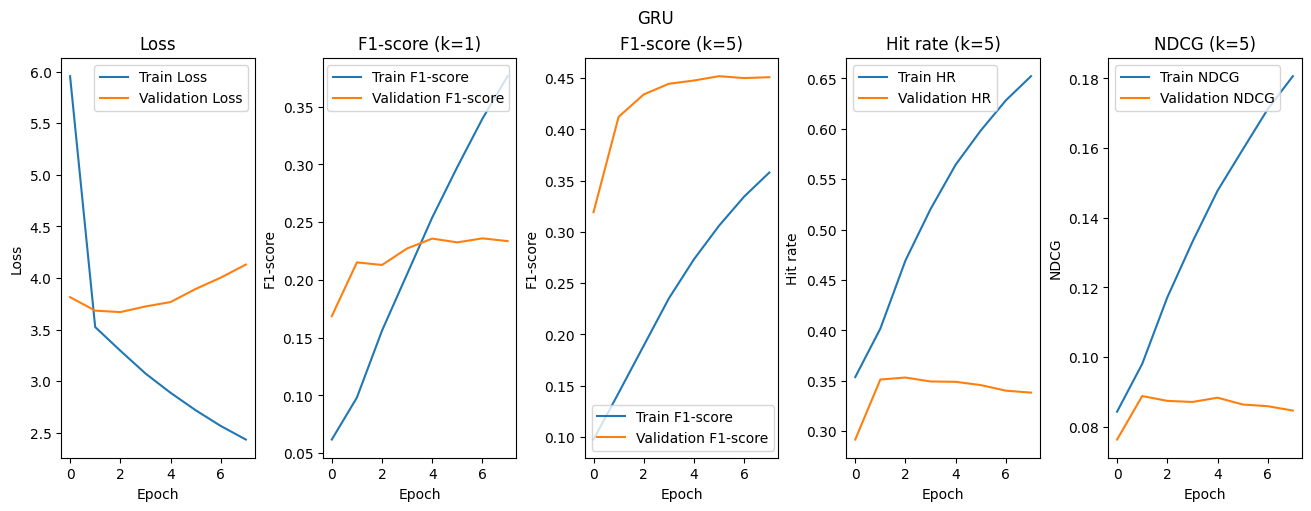

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1429 - f1_score: 0.2200 - f1_score_at_k: 0.4603 - hit_rate_at_k: 0.3384 - loss: 4.0292 - ndcg_at_k: 0.0811
Test loss: 4.1067
Test accuracy: 0.1668
Test F1@1: 0.2446
Test F1@5: 0.4521
Test HR@5: 0.3413
Test NDCG@5: 0.0863


In [42]:
parameters

{'user': 'users-7',
 'user_id': 'A3CG93783LP0FO',
 'number_of_sequences_and_targets_before_removal': 35017,
 'number_of_sequences_and_targets_after_removal': 34360,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 30548,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 16118,
 'number_of_sequences_and_targets_train': 24434,
 'number_of_sequences_and_targets_validation': 3056,
 'number_of_sequences_and_targets_test': 3058,
 'number_of_unique_products_in_targets_train': 101,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.1297197341918945,
 'model_lstm_test_accuracy': 0.1638,
 'model_lstm_test_f1_score_k_1': 0.2366,
 'model_lstm_test_f1_score_k_5': 0.4385,
 'model_lstm_test_hr': 0.3305,
 'model_lstm_test_ndcg': 0.0837,
 'model_bi_lstm_test_loss': 4.355976104736328,
 'model_bi_lstm_test_accuracy': 0.1785,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.0987 - f1_score: 0.0713 - f1_score_at_k: 0.1191 - hit_rate_at_k: 0.2642 - loss: 9.3903 - ndcg_at_k: 0.0616 - val_accuracy: 0.1574 - val_f1_score: 0.1682 - val_f1_score_at_k: 0.3720 - val_hit_rate_at_k: 0.3447 - val_loss: 3.8297 - val_ndcg_at_k: 0.0845
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2002 - f1_score: 0.1036 - f1_score_at_k: 0.1675 - hit_rate_at_k: 0.4935 - loss: 3.3616 - ndcg_at_k: 0.1173 - val_accuracy: 0.1695 - val_f1_score: 0.1792 - val_f1_score_at_k: 0.3742 - val_hit_rate_at_k: 0.3415 - val_loss: 3.7480 - val_ndcg_at_k: 0.0857
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2150 - f1_score: 0.1310 - f1_score_at_k: 0.1839 - hit_rate_at_k: 0.5069 - loss: 3.2895 - ndcg_at_k: 0.1225 - val_accuracy: 0.1692 - val_f1_score: 0.1996 - val_f1_score_at_k: 0.4139 - val_hit_rate_at_k: 0.3542 - val_loss: 3.6872 - val_ndcg_at_k: 0.0885
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7

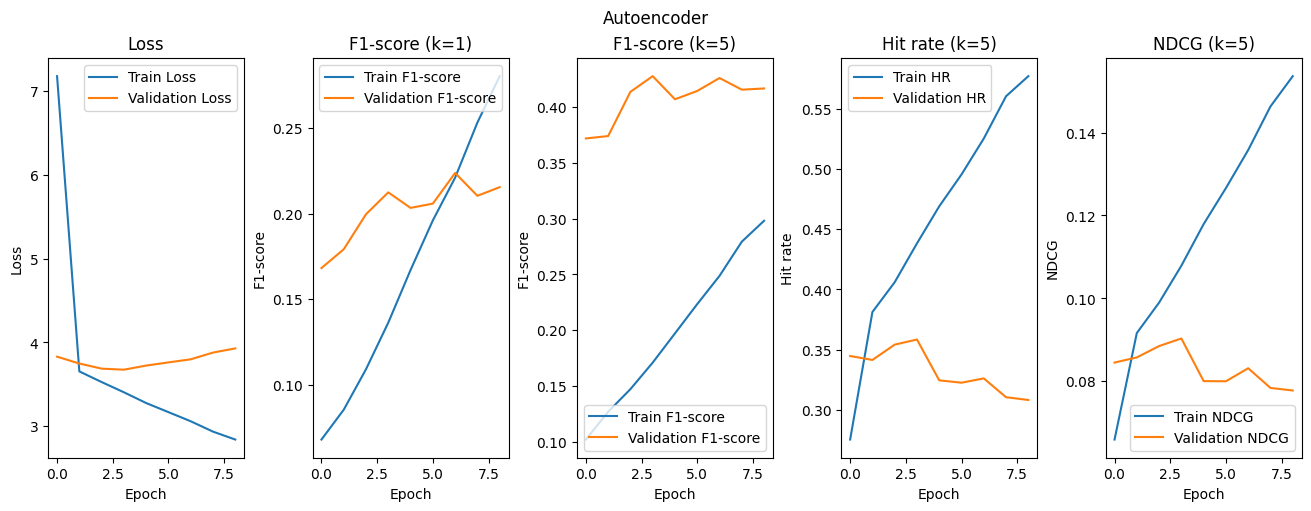

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1487 - f1_score: 0.2250 - f1_score_at_k: 0.4332 - hit_rate_at_k: 0.3209 - loss: 3.8756 - ndcg_at_k: 0.0803
Test loss: 3.9119
Test accuracy: 0.1557
Test F1@1: 0.225
Test F1@5: 0.4191
Test HR@5: 0.3158
Test NDCG@5: 0.0805


In [47]:
parameters

{'user': 'users-7',
 'user_id': 'A3CG93783LP0FO',
 'number_of_sequences_and_targets_before_removal': 35017,
 'number_of_sequences_and_targets_after_removal': 34360,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 30548,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 16118,
 'number_of_sequences_and_targets_train': 24434,
 'number_of_sequences_and_targets_validation': 3056,
 'number_of_sequences_and_targets_test': 3058,
 'number_of_unique_products_in_targets_train': 101,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.1297197341918945,
 'model_lstm_test_accuracy': 0.1638,
 'model_lstm_test_f1_score_k_1': 0.2366,
 'model_lstm_test_f1_score_k_5': 0.4385,
 'model_lstm_test_hr': 0.3305,
 'model_lstm_test_ndcg': 0.0837,
 'model_bi_lstm_test_loss': 4.355976104736328,
 'model_bi_lstm_test_accuracy': 0.1785,
 'model_bi_lstm_test_f1_score_k_1': 0

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A3CG93783LP0FO', 'sequence': [137674, 124153], 'target': 88222}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 1.0
NDCG@10: 0.06943121552467346
-------------
HT@20: 1.0
NDCG@20: 0.04480864480137825
-------------
HT@50: 1.0
NDCG@50: 0.02445894107222557
-------------
HT@100: 1.0
NDCG@100: 0.015066135674715042
-------------
HT@200: 1.0
NDCG@200: 0.00906037911772728
-------------
HT@300: 1.0
NDCG@300: 0.006658346392214298
-------------
HT@400: 1.0
NDCG@400: 0.005327714141458273
-------------
HT@500: 1.0
NDCG@500: 0.004471076652407646
-------------
